# Library and dataset import section: 

In [1]:
!featurize dataset download 3b2d6527-7a46-4237-84b5-605c9f9165fa

100%|████████████████████████████████████████| 506M/506M [00:02<00:00, 176MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
import torchvision.models as models

In [3]:
import pywt
import pywt.data
import numpy as np

# Image pre-process section:

In [45]:
# Resize image to fixed size
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def prepare_image(image_path, image_size):
    h = image_size[0]
    w = image_size[1]
    convert_tensor = transforms.ToTensor()
    image = Image.open(image_path).convert('RGB')
    dwt = pywt.dwt2(np.array(image.resize(image_size)), 'db1')
    result = np.vstack((dwt[1][0].reshape(h,w,1), dwt[1][1].reshape(h,w,1), dwt[1][2].reshape(h,w,1)))
    # result = result.reshape(3, h, w)
    return convert_tensor(result).reshape(3, h, w)

In [46]:
path = 'data/CASIA2000/Au/Au_ani_00007.jpg'
res = prepare_image(path, (224,224))
print(res.shape)

torch.Size([3, 224, 224])


# Real image

In [55]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real

In [56]:
image_size = (224, 224) 
path = 'data/CASIA2000/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if '.ipynb_checkpoints' in full_path:
            continue
        X.append(prepare_image(full_path, image_size))
        Y.append(1)

print(len(X), len(Y))

960 960


# Fake image

In [57]:
# fake images

image_size = (224, 224) 
path = 'data/CASIA2000/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        if '.ipynb_checkpoints' in full_path:
            continue
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

1920 1920


# Shuffle and split the data

In [58]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [59]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

1382 1382
384 384
154 154


In [60]:
# Create dataloader
BATCH_SIZE = 64

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

# VGG model

In [31]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [12]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [13]:
# Binary classification: fake or real
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M']
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

OUTPUT_DIM = 2
model = VGG(vgg16_layers, OUTPUT_DIM)

In [14]:
pretrained_model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/featurize/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.classifier[-1] = final_fc

pretrained_model.features = pretrained_model.features[:24]
pretrained_model.classifier = None

print(pretrained_model.classifier)
print(pretrained_model.features)

None
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [16]:
model.load_state_dict(pretrained_model.state_dict(), strict = False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'], unexpected_keys=[])

In [17]:
# Learning rate
LR = 1e-3
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]
optimizer = optim.Adam(params, lr=LR, weight_decay = 0.001, amsgrad = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training stage

In [62]:
# Trains the model using backpropagation
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.Module, torch.device
# Output: float, float
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device, dtype=torch.float)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [63]:
# Calculates time elapsed for the whole training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [64]:
# Calculates the loss and accuracy of the model with the given criterion
# Input: torch.nn.Module, data.Dataloader, torch.nn.Module, torch.device
# Output: float, float
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device, dtype=torch.float)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [65]:
EPOCHS = 30
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'vgg16-3layers-1st-dwt.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 1.525 | Train Acc: 47.30%
	Val. Loss: 0.695 |  Val. Acc: 43.03%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.695 | Train Acc: 50.19%
	Val. Loss: 0.692 |  Val. Acc: 56.45%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.695 | Train Acc: 50.40%
	Val. Loss: 0.680 |  Val. Acc: 56.97%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.694 | Train Acc: 53.22%
	Val. Loss: 0.680 |  Val. Acc: 55.41%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.682 | Train Acc: 56.21%
	Val. Loss: 0.673 |  Val. Acc: 54.89%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.685 | Train Acc: 55.57%
	Val. Loss: 0.665 |  Val. Acc: 57.73%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.669 | Train Acc: 60.73%
	Val. Loss: 0.649 |  Val. Acc: 69.91%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.645 | Train Acc: 64.92%
	Val. Loss: 0.649 |  Val. Acc: 62.66%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.595 | Train Acc: 68.31%
	Val. Loss: 0.658 |  Val. Acc: 60.62%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.554 | Train Acc: 70.39%
	Val. Loss: 1.029 |  Val. Acc: 44.07%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.569 | Train Acc: 70.09%
	Val. Loss: 0.628 |  Val. Acc: 70.67%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.492 | Train Acc: 77.29%
	Val. Loss: 0.741 |  Val. Acc: 60.38%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.446 | Train Acc: 78.95%
	Val. Loss: 0.680 |  Val. Acc: 62.42%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.417 | Train Acc: 81.00%
	Val. Loss: 0.675 |  Val. Acc: 64.22%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.345 | Train Acc: 85.53%
	Val. Loss: 0.855 |  Val. Acc: 63.70%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.318 | Train Acc: 86.85%
	Val. Loss: 0.857 |  Val. Acc: 59.82%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.284 | Train Acc: 88.02%
	Val. Loss: 0.884 |  Val. Acc: 62.94%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.210 | Train Acc: 92.23%
	Val. Loss: 0.945 |  Val. Acc: 61.38%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.308 | Train Acc: 87.12%
	Val. Loss: 0.804 |  Val. Acc: 64.98%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.209 | Train Acc: 92.49%
	Val. Loss: 1.062 |  Val. Acc: 60.90%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.163 | Train Acc: 93.98%
	Val. Loss: 1.143 |  Val. Acc: 66.83%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.181 | Train Acc: 92.51%
	Val. Loss: 1.071 |  Val. Acc: 64.74%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.151 | Train Acc: 94.91%
	Val. Loss: 1.083 |  Val. Acc: 61.90%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.126 | Train Acc: 95.69%
	Val. Loss: 1.379 |  Val. Acc: 62.94%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.142 | Train Acc: 94.19%
	Val. Loss: 1.197 |  Val. Acc: 66.31%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.130 | Train Acc: 95.31%
	Val. Loss: 1.285 |  Val. Acc: 60.62%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.142 | Train Acc: 94.82%
	Val. Loss: 1.146 |  Val. Acc: 59.33%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.122 | Train Acc: 95.45%
	Val. Loss: 1.207 |  Val. Acc: 67.35%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.109 | Train Acc: 96.52%
	Val. Loss: 1.505 |  Val. Acc: 60.90%


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.114 | Train Acc: 95.64%
	Val. Loss: 1.291 |  Val. Acc: 61.90%


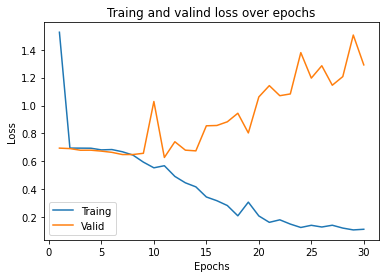

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Lowest loss happens in epoch 11
Total Time Spent: 1.0m 20s
Test Loss: 0.622 | Test Acc: 67.45%


In [66]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Evaluation
model.load_state_dict(torch.load('vgg16-3layers-1st-dwt.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')